In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import cdd
from modulus_tools import demo_graphs
from modulus_tools import algorithms as alg
from itertools import product
from itertools import combinations
import networkx as nx

In [27]:
def steiner_trees(G,w):   
    n = len(G.nodes)
    for i in range(1,n):
        for T in combinations(G.edges,n-1):
            H = nx.Graph(T)
            stei= []
            if nx.is_tree(H):
                for x in w:
                    for y in w:
                        M = nx.Graph()
                        nx.add_path(M,nx.shortest_path(H,x,y))
                        stei = stei+ list(M.edges())    
                yield(stei)

In [28]:
G, pos = demo_graphs.slashed_house_graph()
for i, (u,v) in enumerate(G.edges()):
    G[u][v]['enum'] = i
trees = list(steiner_trees(G,[1,3,4]))


In [29]:
# count the number of edges
m = len(G.edges)

# initialize an empty list of rows for the augmented matrix
rows = []

# add rows corresponding to the constraints rho >= 0
for i in range(m):
    row = (m+1)*[0]
    row[i+1] = 1
    rows.append(row)
    
# add rows corresponding to the constraints N*rho >= 1
for tree in trees:
    row = [-1] + m*[0]
    for u,v in tree:
        i = G[u][v]['enum']
        row[i+1] = 1
    rows.append(row)
    
# create the polyhedron in cdd
mat = cdd.Matrix(rows, number_type='fraction')
mat.rep_type = cdd.RepType.INEQUALITY
poly = cdd.Polyhedron(mat)
ext = poly.get_generators()
print(ext)

V-representation
begin
 19 8 rational
 1 0 0 0 1 0 1 1
 1 0 1/2 1/2 1/2 1/2 0 1/2
 1 0 1/2 0 1/2 0 1/2 1/2
 1 0 1 0 1 0 1 0
 1 0 1 0 0 0 0 1
 1 0 0 1 1 1 0 1
 1 0 1 1 1 1 0 0
 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 1 0
 1 1/2 0 1/2 1/2 1/2 0 1/2
 1 1/2 0 1/2 1/2 0 1/2 1/2
 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0
end


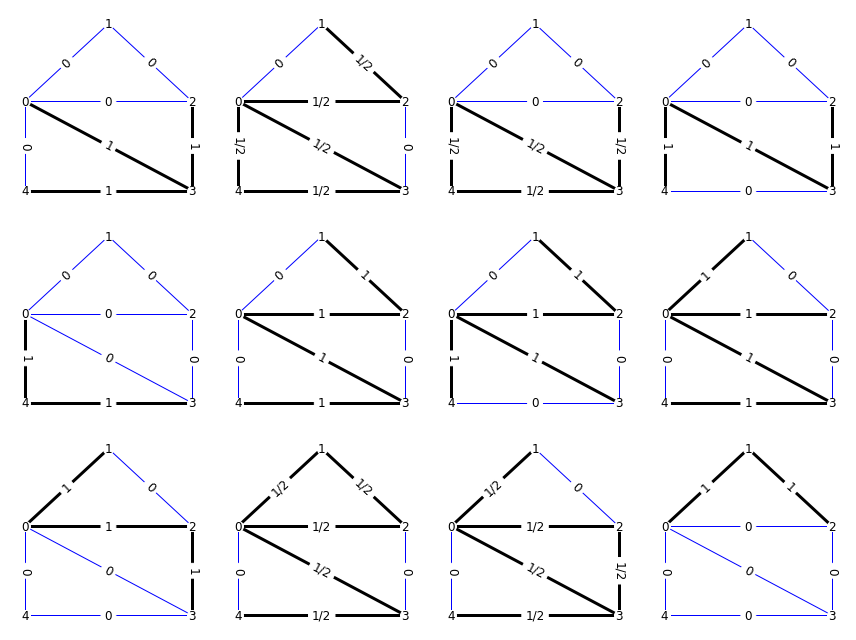

In [30]:
# list of dual objects
dual = []

# loop over extreme points and directions
for i in range(ext.row_size):
    
    # skip extreme directions
    if ext[i][0] == 0:
        continue
        
    # add the vector representation of the dual object
    dual.append(ext[i][1:])
    
# number of columns and rows for plot
ncol = 4
nrow = int(np.ceil(len(dual)/ncol))

# draw the trees
plt.figure(figsize=(3*ncol,3*nrow))

# draw the blocker
for i, obj in enumerate(dual):
    plt.subplot(nrow,ncol,i+1)
    labels = {(u,v):obj[d['enum']] for u,v,d in G.edges(data=True)}
    edges = [(u,v) for u,v,d in G.edges(data=True) if obj[d['enum']] > 0]
    nx.draw(G, pos, node_size=100, node_color='white', edge_color='blue')
    labelsnode = {u:u for u in G.nodes}
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=3)
    nx.draw_networkx_labels(G, pos,labels=labelsnode, font_size=12)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)
plt.tight_layout()